## Preprocess Section

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# The libsvm library probably is the one that it tells to be used
from libsvm.svmutil import svm_problem, svm_parameter, svm_train, svm_predict
from scipy.io import loadmat
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import butter, freqs, sosfilt, periodogram, welch
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
# Load right pocket data from subject 1
mat = loadmat('./generated dataset/subject_1_right_pocket.mat')


In [3]:
# Get the meter of the vector of the 3 axis
acceleration_meter = np.sqrt(mat['x'][:,0]**2 + mat['x'][:,1]**2 + mat['x'][:,2]**2)

In [4]:
# This function is used to make the values that are above 1000 to be the same as the previous value as described in the assignment
def filter_values(values):
    # Loop through the values
    for i in range(len(values)):
        # If the value is above 1000, make it the same as the previous value
        if values[i] > 1000:
            values[i] = values[i-1]
    return values

In [5]:
# Apply high pass butterworth filter of cutoff frequency 1 Hz
def butter_filter(order, cutoff=1, type='highpass'):
    # Get the filter coefficients
    # N is the order of the filter
    # Wn is the critical frequency
    # btype is the type of the filter
    # analog=False means that the filter is digital
    # output='sos' should be used for general-purpose filtering.
    # fs is the sampling frequency which is said to be 100 Hz in the assignment
    # TODO: Check if the sampling frequency here is correct or should be set to the double 200 Hz
    sos = butter(N=order, Wn=cutoff, btype=type, analog=False, output='sos', fs=100)
    return sos

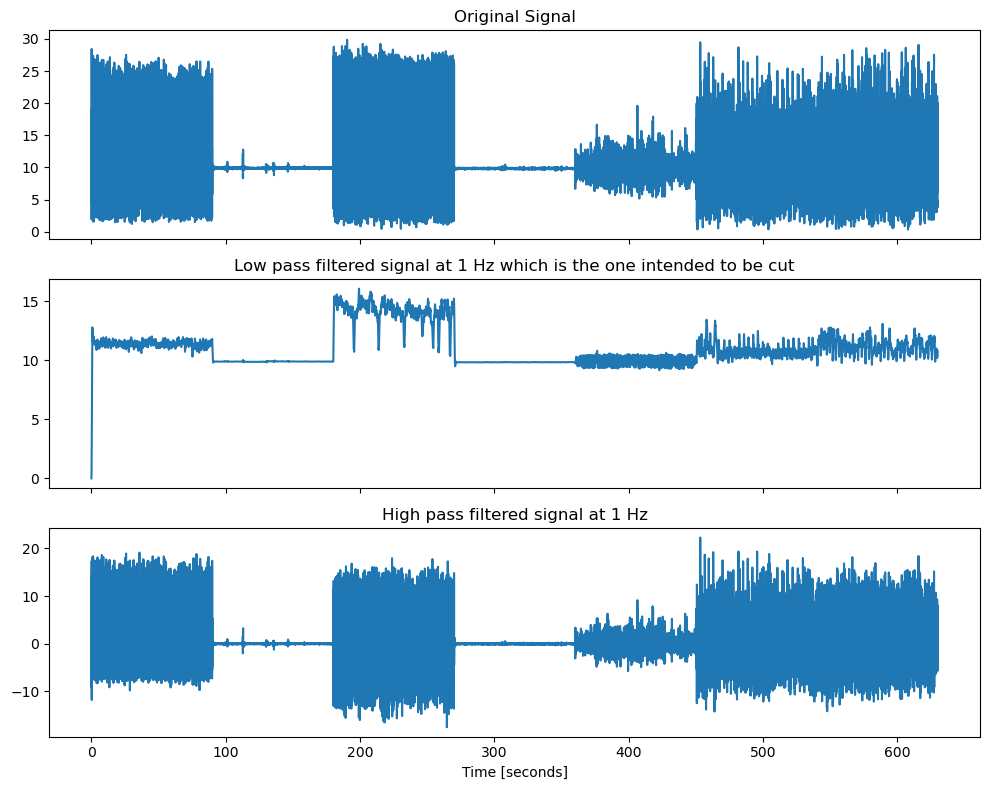

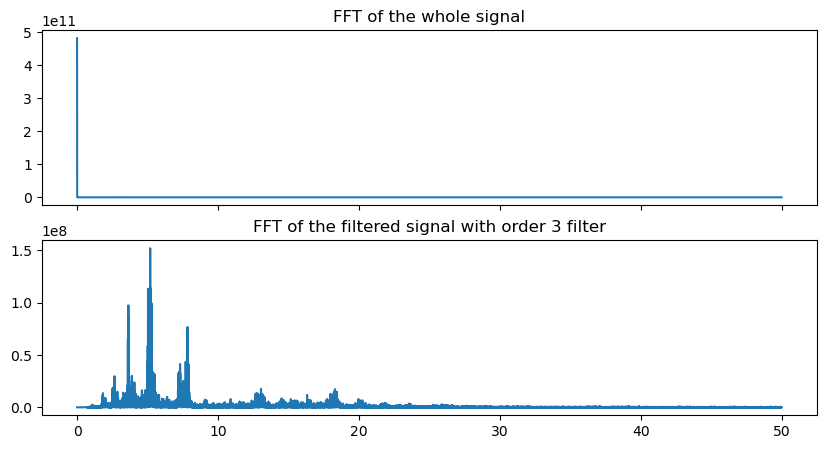

In [6]:
# This is a test part to see if the filter works

# Plot the 500 first values of signal
n = 63000

# Set the cutoff frequency
cutt_off_frequency = 1
order = 3

# Create the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot the original signal
ax1.plot(mat['t'][:n], acceleration_meter[:n])
ax1.set_title('Original Signal')

# Create and apply the lowpass filter
sos = butter_filter(order, cutoff=cutt_off_frequency, type='lowpass')
filtered = sosfilt(sos, acceleration_meter[:n])
# Plot the filtered signal
ax2.plot(mat['t'][:n], filtered[:n])
ax2.set_title(f'Low pass filtered signal at {cutt_off_frequency} Hz which is the one intended to be cut')

# Create and apply the highpass filter
sos = butter_filter(order, cutoff=cutt_off_frequency, type='highpass')
filtered = sosfilt(sos, acceleration_meter[:n])

# Plot the filtered signal
ax3.plot(mat['t'][:n], filtered[:n])
ax3.set_title(f'High pass filtered signal at {cutt_off_frequency} Hz')
ax3.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
N = n
T = 0.01
yf_before = np.abs(fft(acceleration_meter[:n]))**2
xf = fftfreq(N, T)
ax1.plot(xf[:N//2], yf_before[:N//2])
ax1.set_title('FFT of the whole signal');
# fft of the filtered signal
yf_after = np.abs(fft(filtered))**2
xf = fftfreq(N, T)
ax2.plot(xf[:N//2], yf_after[:N//2])
ax2.set_title(f'FFT of the filtered signal with order {order} filter');

In [7]:
energy_before = yf_before[:N//2]
energy_after = yf_after[:N//2]

In [8]:
energy_after[630]/energy_before[630]

0.5262948103733397

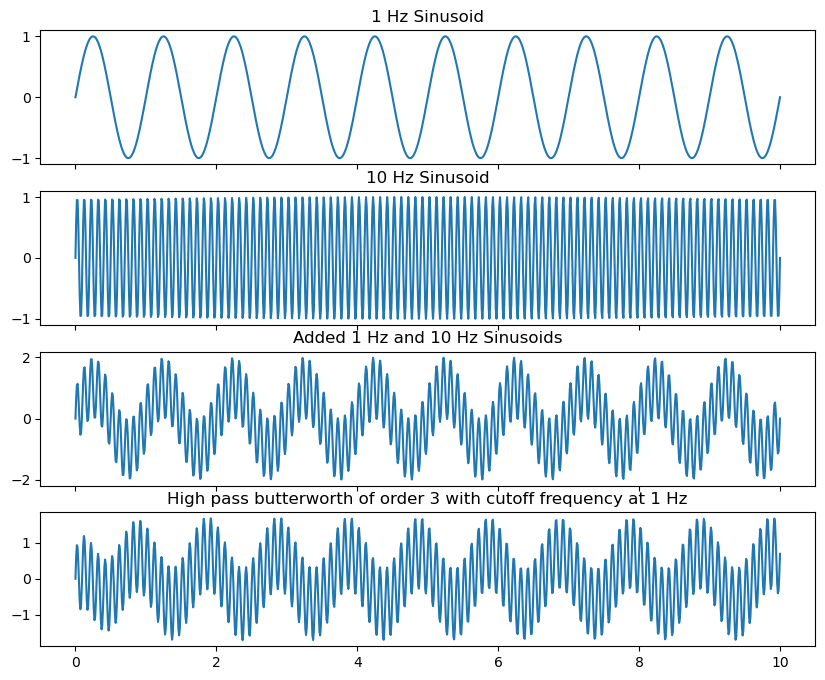

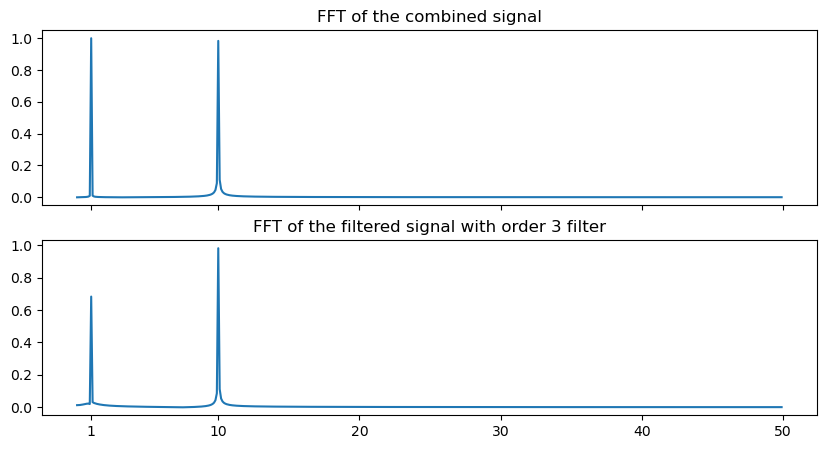

In [9]:
# the durations is in s
duration = 10
# the sampling frequency is 100 Hz so thats why i multiply by 100
t_duration = np.linspace(0,duration,duration*100)
# order of the filter
order = 3

# Second frequency to be added
second_freq = 10

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
# create a signal of 1 Hz
sign1 = np.sin(2*np.pi*1*t_duration)
ax1.plot(t_duration, sign1)
ax1.set_title('1 Hz Sinusoid');
# create a signal of 2 Hz
sign2 = np.sin(2*np.pi*second_freq*t_duration)
ax2.plot(t_duration, sign2)
ax2.set_title(f'{second_freq} Hz Sinusoid');
# Added the two signals
sign3 = sign1 + sign2
ax3.plot(t_duration, sign3)
ax3.set_title(f'Added 1 Hz and {second_freq} Hz Sinusoids');
# Applied high pass filter at 1 Hz
sos = butter_filter(order, cutoff=1, type='highpass')
filtered_signal = sosfilt(sos, sign3)
ax4.plot(t_duration, filtered_signal)
ax4.set_title(f'High pass butterworth of order {order} with cutoff frequency at 1 Hz');
# fft of the signal
# sample spacing
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
N = duration*100
T = 0.01
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(sign3)
xf = fftfreq(N, T)[:N//2]
ax1.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax1.set_title('FFT of the combined signal');
# fft of the filtered signal
yf = fft(filtered_signal)
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax2.set_title(f'FFT of the filtered signal with order {order} filter');
ax2.xaxis.set_ticks([1,10,20,30,40,50]);

In [10]:
# This function is made to have one function for all the preprocessing steps
def load_and_process_signal(path, filter_order, cutt_off_frequency, step):
    # load data
    data = loadmat(path)

    # convert x,y,z to a one meter of vector - PREPROCESS STEP 2
    acc_meter = np.sqrt(data['x'][:,0]**2 + data['x'][:,1]**2 + data['x'][:,2]**2)

    # filter values that are above 1000 - PREPROCESS STEP 3
    acc_meter = filter_values(acc_meter)
    
    # Create and apply the highpass filter - PREPROCESS STEP 4
    filter = butter_filter(order=filter_order, cutoff=cutt_off_frequency, type='highpass')
    filtered_signal = sosfilt(filter, acc_meter)

    # split signal into smaller ones of one second duration 
    fraction_signals = []
    # iterate over the signal with a step (default 100 = 1s)
    for i in range(0, len(filtered_signal), step):
        # Get the fraction signal
        fraction_signals.append(filtered_signal[i:i+step])
    # Initialize the features array
    features_array = []
    for signal in fraction_signals:
        # Calculate the power spectrum of the signal with the welch method
        # TODO: Check if the sampling frequency is correct, also if the scaling should be this one and finally if the average should be median or mean
        f, Pxx = welch(signal, fs=200, return_onesided=True, scaling='spectrum', average='mean', nfft=2**11, nperseg = 100);
        # Initialize the features list
        features = []
        for fracture in range(0,10):
            # Calculate the lower and upper bound of the power spectrum
            lower = 2**fracture
            upper = 2**(fracture+1)
            # Get the power spectrum of the signal from fracture to fracture+1 - CHARACTERISTICS EXTRACTION STEP
            power = Pxx[lower:upper]
            # Append the sum of the power spectrum to the features list
            features.append(power.sum())
        # Append the features to the features array
        features_array.append(features)
    return fraction_signals, features_array

#### Here are the settings that we are tuning for the assigment
- step = The window frames that we are going to take is in seconds but later on as you can see we multiply *100 because the frequency is 100Hz so 1s are 100 samples

In [11]:
# Set the step to sample in seconds
step_s = 1
# Set the filter order
filter_order = 3

In [12]:
step = step_s * 100
subjects = ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10']
# ['right_pocket', 'left_pocket', 'upper_arm', 'belt', 'wrist']
position = 'left_pocket'

if not os.path.exists(f'./images/{position}/step_{step_s}'):
    os.makedirs(f'./images/{position}/step_{step_s}')


fraction_signals = []
human_data = []
human_targets = []
for subject in subjects:
    # Load the ground truth for the specified human
    ground_truth = loadmat(f'./generated dataset/{subject}_ground_truth.mat')
    # Initialize the target list
    target = []
    # Extract the target from the ground truth because it is saved in matlab format
    for i in range(0, len(ground_truth['label'])):
        target.append(ground_truth['label'][i][0][0])
    labels = []
    # iterate over the signal with a step of 100 because the sampling frequency is 100 Hz so 100 samples in one second
    for i in range(0, 63000, step):
        # Get the label with the highest count in the 100 samples for activity
        labels.append(pd.DataFrame(target[i:i+step]).value_counts().keys()[0][0])
    human_targets.append(labels)

    # Get data from position
    fraction_signal, features_array = load_and_process_signal(f'./generated dataset/{subject}_{position}.mat', filter_order, cutt_off_frequency=1, step=step)
    fraction_signals.append(fraction_signal)
    human_data.append(features_array)

In [13]:
# Standardize the data
human_data = np.array(human_data)
human_targets = np.array(human_targets)

means = []
stds = []
# Calculate the mean and standard deviation of each feature from all humans and all positions - STANDARDIZATION STEP
for i in range(10):
    means.append(human_data[:,:,i].mean())
    stds.append(human_data[:,:,i].std())
# Standardize the features as said in the assignment
for i in range(10):
    human_data[:,:,i] = (human_data[:,:,i] - means[i]) / stds[i]

In [14]:
# There is a problem in the data so we need to replace the words upsatirs with upstairs
print(np.unique(human_targets))
# Replace the upsatirs with upstairs
human_targets = np.where(human_targets == 'upsatirs', 'upstairs', human_targets)
print(np.unique(human_targets))

['biking' 'downstairs' 'jogging' 'sitting' 'standing' 'upsatirs'
 'upstairs' 'walking']
['biking' 'downstairs' 'jogging' 'sitting' 'standing' 'upstairs' 'walking']


In [15]:
print('The shape of human data is:      ', human_data.shape)
print('The shape of human targets is:   ', human_targets.shape)

The shape of human data is:       (10, 630, 10)
The shape of human targets is:    (10, 630)


In [16]:
# Create a dataset with the human data and targets
human_dataset = pd.DataFrame()
for i in range(10):
    human_dataset[f'feature_{i}'] = human_data[:,:,i].flatten()
human_dataset['targets'] = human_targets.flatten()

In [17]:
# create folder to save the images
if not os.path.exists('./images'):
    os.makedirs('./images')

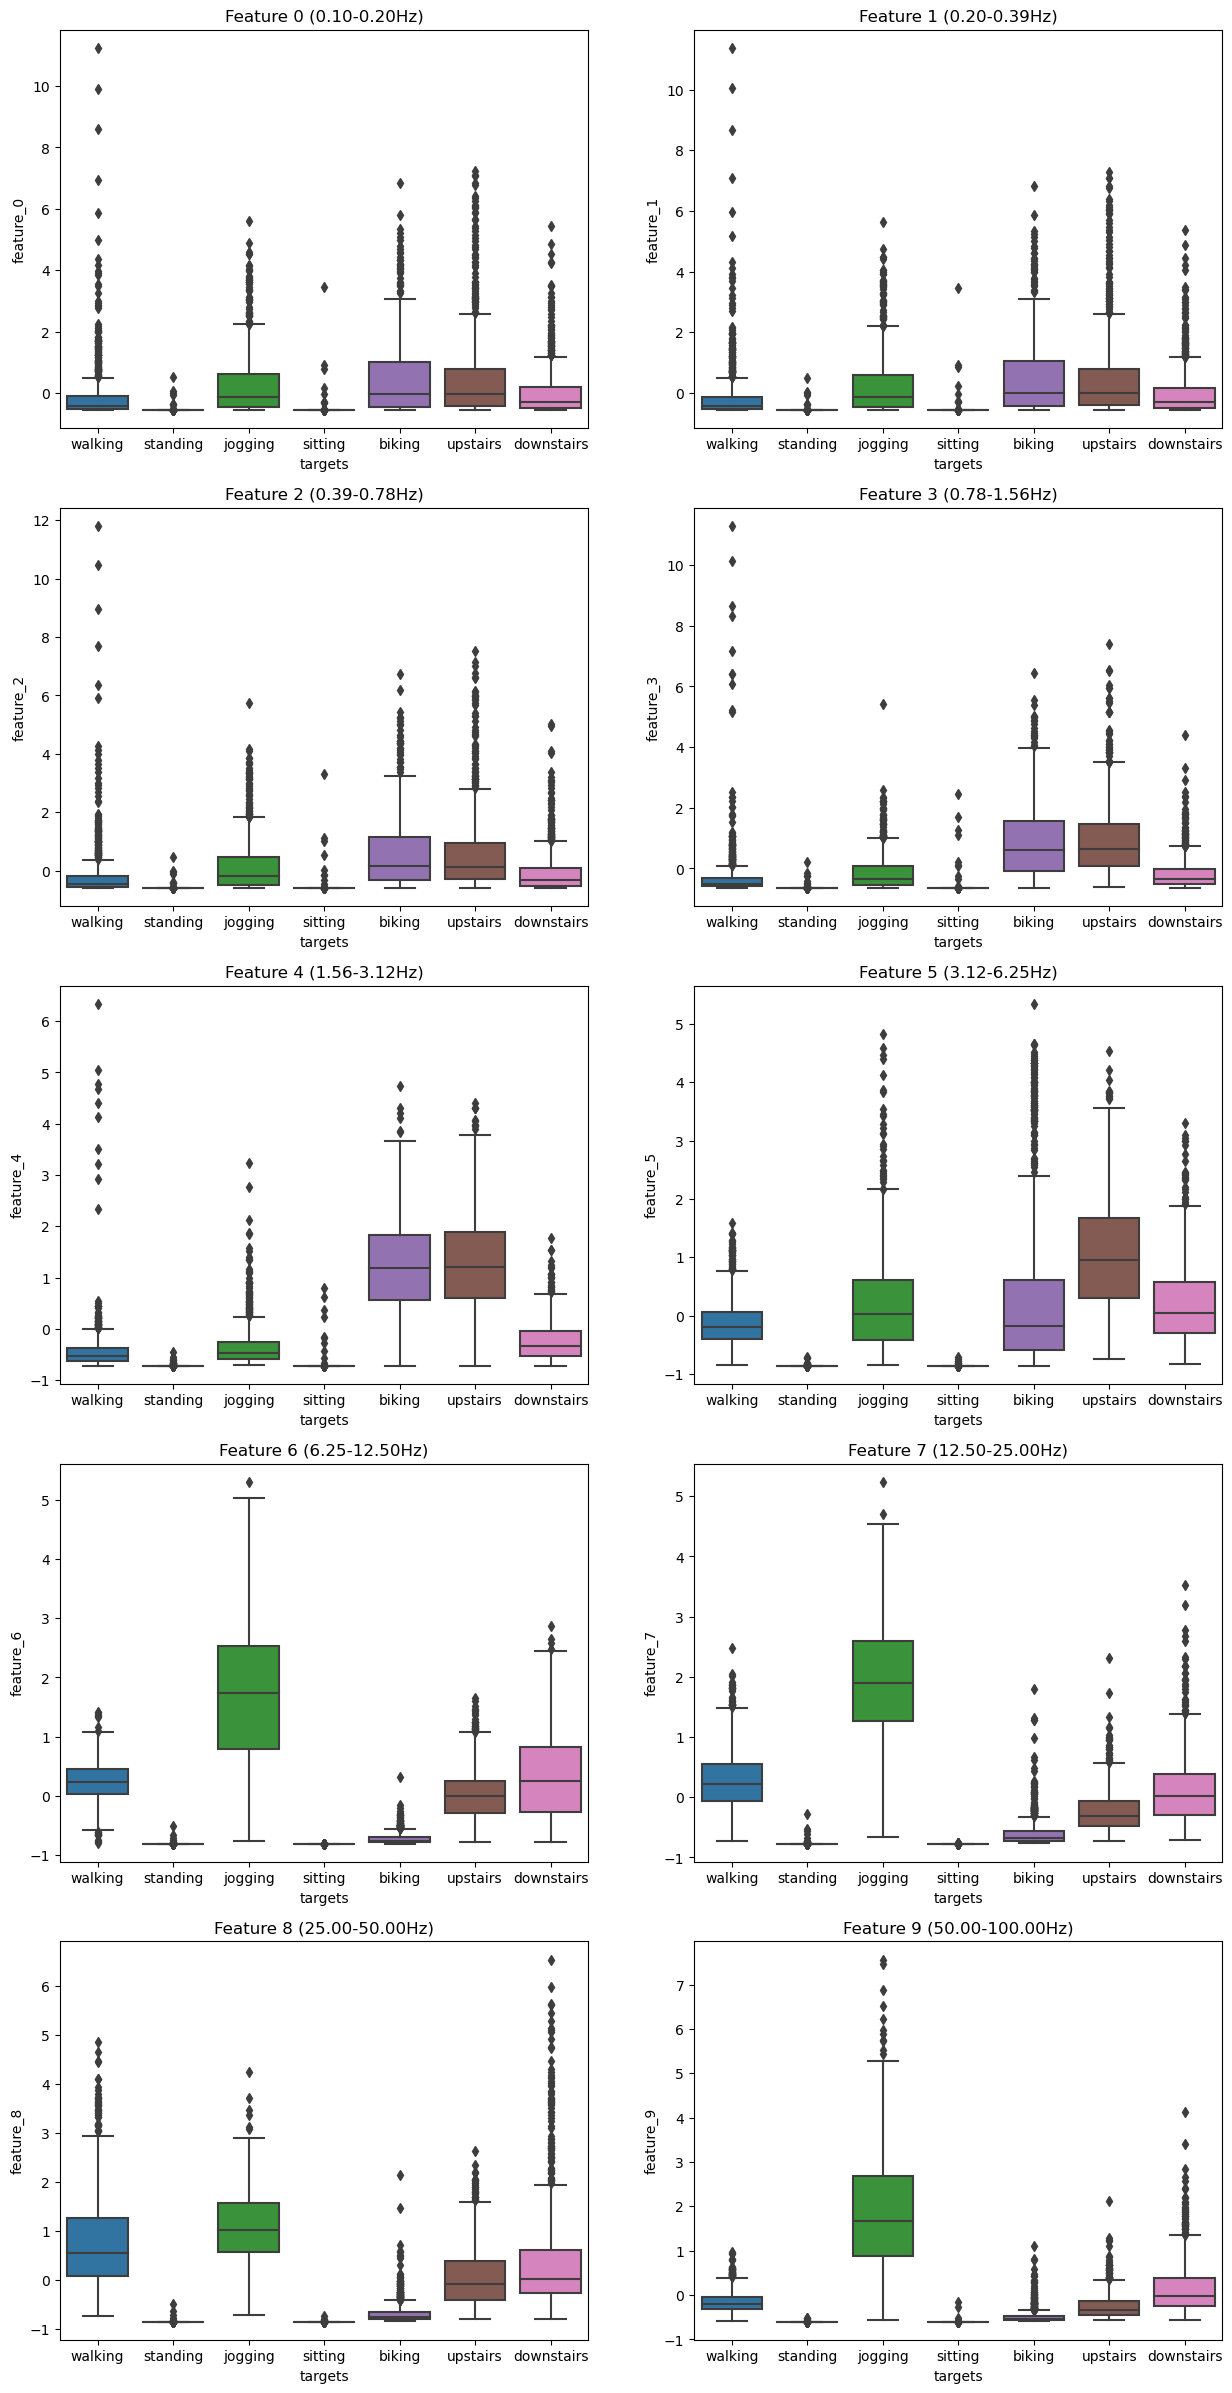

In [19]:
# Plot activity statistics based on the features
fig, ax = plt.subplots(5,2, figsize=(15,30))
# Iterate over the features
for i in range(10):
    # Plot the boxplot of the feature
    sns.boxplot(x='targets', y=f'feature_{i}', data=human_dataset, ax=ax[i//2, i%2])
    lower = (2**i/2**10)*100
    upper = (2**(i+1)/2**10)*100
    ax[i//2, i%2].set_title(f'Feature {i} ({lower:.2f}-{upper:.2f}Hz)')
# make dir for step
plt.savefig(f'./images/{position}/step_{step_s}/boxplot_{position}.png')


In [20]:
# One hot encode the target in order to get the correlation matrix
corr_dataset = pd.get_dummies(human_dataset, columns=['targets'])

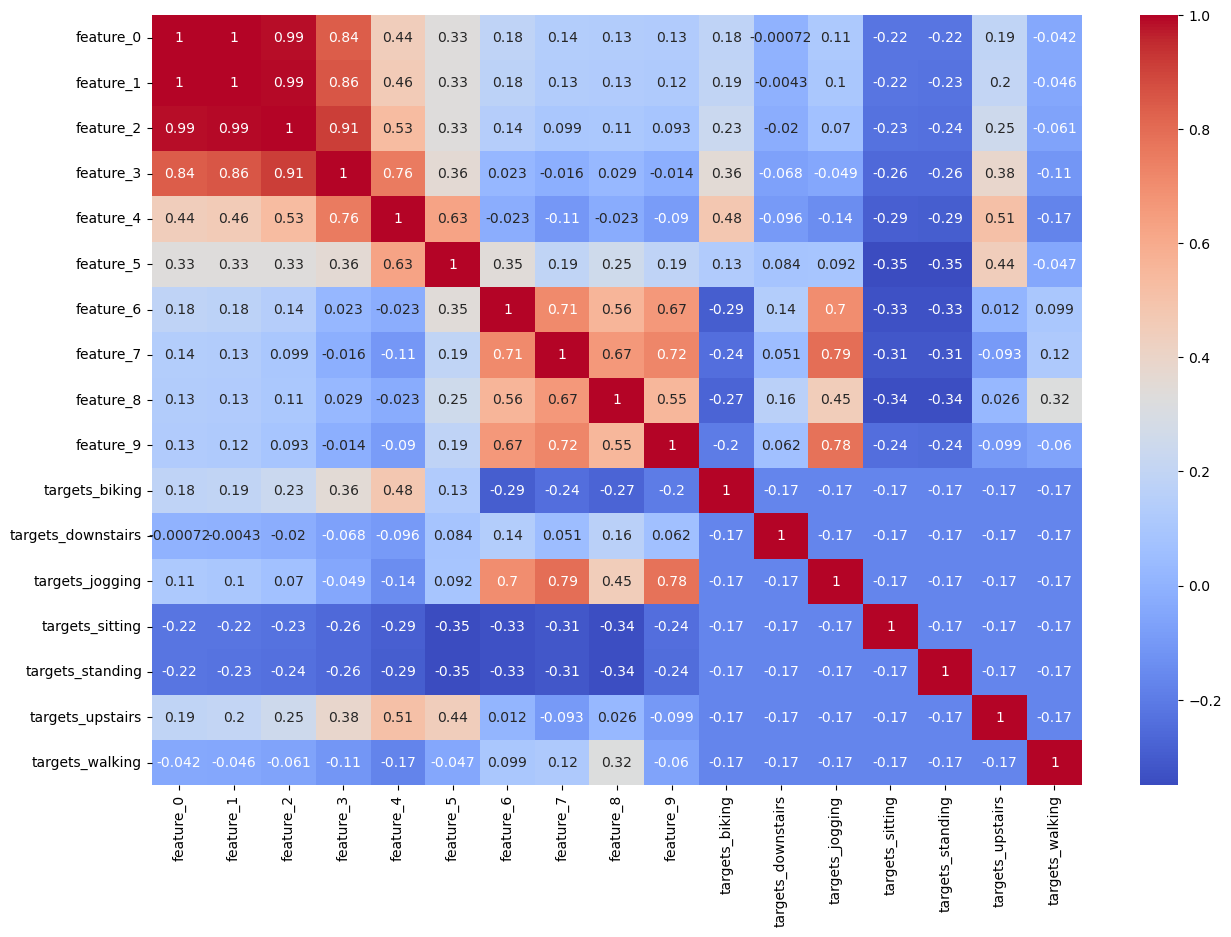

In [21]:
# Plot the correlation matrix of the features and the target
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_dataset.corr(), annot=True, ax=ax, cmap='coolwarm')
plt.show()

## Train SVM classifier

The code for the LibSVM classifier was taken from this library guide [Libsvm-official](https://pypi.org/project/libsvm-official/) hope this is the correct one

Mapping activities to ids {'biking': 0, 'downstairs': 1, 'jogging': 2, 'sitting': 3, 'standing': 4, 'upstairs': 5, 'walking': 6} 

SklearnSVM: Accuracy for subject out 1: 74.44%
LibSVM:   Accuracy for subject out 1: 74.60% 

SklearnSVM: Accuracy for subject out 2: 76.51%
LibSVM:   Accuracy for subject out 2: 76.35% 

SklearnSVM: Accuracy for subject out 3: 71.59%
LibSVM:   Accuracy for subject out 3: 71.59% 

SklearnSVM: Accuracy for subject out 4: 77.78%
LibSVM:   Accuracy for subject out 4: 77.78% 

SklearnSVM: Accuracy for subject out 5: 74.60%
LibSVM:   Accuracy for subject out 5: 74.60% 

SklearnSVM: Accuracy for subject out 6: 74.92%
LibSVM:   Accuracy for subject out 6: 74.92% 

SklearnSVM: Accuracy for subject out 7: 72.86%
LibSVM:   Accuracy for subject out 7: 72.86% 

SklearnSVM: Accuracy for subject out 8: 77.94%
LibSVM:   Accuracy for subject out 8: 77.94% 

SklearnSVM: Accuracy for subject out 9: 68.41%
LibSVM:   Accuracy for subject out 9: 68.41% 

SklearnSVM: Accuracy fo

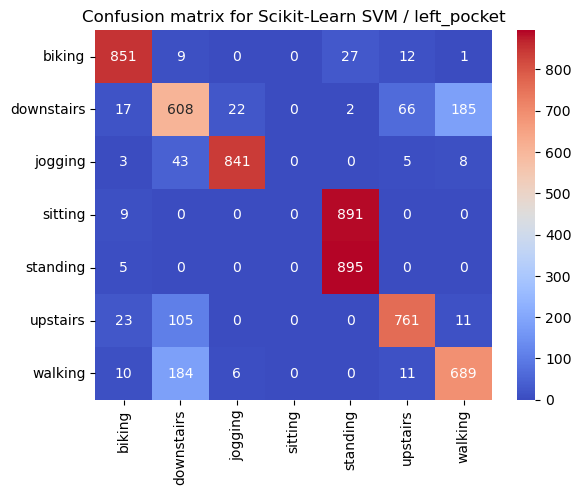

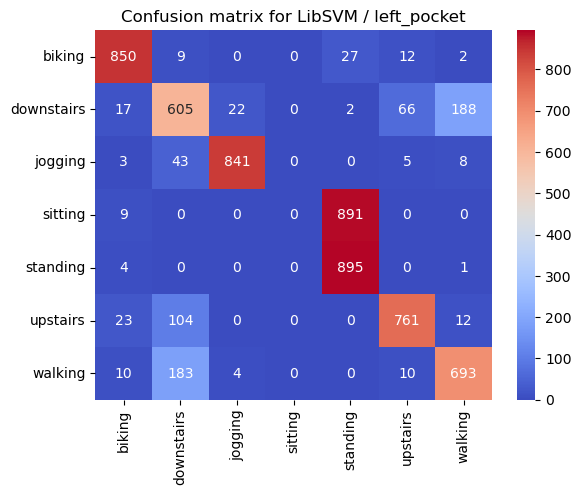

In [22]:
# Perform one subject out cross validation

# Add the activities to a list because it will be needed by the confusion matrix
activities = ['biking', 'downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']
# Create a dictionary to map the activities to numbers
activities_to_numbers = dict(zip(activities, range(7)))
print(f'Mapping activities to ids {activities_to_numbers} \n');
# Initialize the total confusion matrices in order to start adding the calculated confusion matrices for all subjects-out
total_confusion_matrix_sklearn_svm = np.zeros((7,7))
total_confusion_matrix_lib_svm = np.zeros((7,7))
# total_confusion_matrix_dense_nn = np.zeros((7,7))

# Iterate over the subjects
for subject in range(10):
    # Initialize the test and train data and targets
    test_data = []
    test_targets = []
    train_data = []
    train_targets = []
    # Iterate over the subjects
    for i in range(10):
        # If the subject is the one that is left out
        if i == subject:
            # Append the data and targets to the test data and targets
            test_data = human_data[i]
            test_targets = human_targets[i]
        else:
            # Append the data and targets to the train data and targets
            train_data.append(human_data[i])
            train_targets.append(human_targets[i])
    # Convert the train data and targets to numpy arrays in order to be able to use the function that numpy offers
    train_data = np.array(train_data)
    train_targets = np.array(train_targets)
    # Use SVM as classifier with rbf kernel and gamma=1/p and C=1 where p the dimension of the features
    clf = SVC(kernel='rbf', gamma='auto', C=1)
    # Flatten the train data and targets
    train_data = train_data.reshape(-1, 10)
    train_targets = train_targets.reshape(-1)
    # Fit the SVM classifier
    clf.fit(train_data, train_targets)
    # Fit the LibSVM classifier
    # The target should be numbers so i convert them using the dictionary that map activities to ids
    train_y = [activities_to_numbers[target] for target in train_targets]
    # This is the way that library libSVM show in the example
    prob  = svm_problem(train_y, train_data)
    param = svm_parameter('-c 1')
    m = svm_train(prob, param)
    # Train the Dense model
    # model = create_model();
    # model.fit(train_data, to_categorical(train_y), epochs=100, verbose=0)
    # Flatten the test data
    test_data = test_data.reshape(-1, 10)
    # Also change the test target to ids to be used by the LibSVM classifier
    test_y = [activities_to_numbers[target] for target in test_targets]
    # Predict the test data with the scipy svm classifier
    predictions = clf.predict(test_data)
    # Predict the test data with the LibSVM classifier
    p_label, p_acc, p_val = svm_predict(test_y, test_data, m, '-q');
    # Predict the test data with the LSTM model
    # predictions_dense = model.predict(test_data)
    # predictions_dense = np.argmax(predictions_dense, axis=1)
    # Print the accuracy
    print(f'SklearnSVM: Accuracy for subject out {subject+1}: {accuracy_score(test_targets, predictions)*100:.2f}%')
    print(f'LibSVM:   Accuracy for subject out {subject+1}: {p_acc[0]:.2f}% \n')
    # print(f'DenseNN:  Accuracy for subject out {subject+1}: {accuracy_score(test_y, predictions_dense)*100:.2f}% \n')
    # Add the calculated confusion matrix to the total confusion matrix
    total_confusion_matrix_sklearn_svm += confusion_matrix(test_targets, predictions)
    total_confusion_matrix_lib_svm += confusion_matrix(test_y, p_label)
# Plot the confusion matrix
classifiers = ['Scikit-Learn SVM', 'LibSVM']
for i, conf_matrix in enumerate([total_confusion_matrix_sklearn_svm, total_confusion_matrix_lib_svm]):
    ax = plt.axes()
    sns_heatmap = sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=activities, yticklabels=activities, cmap='coolwarm', ax=ax);
    classifier = classifiers[i]
    ax.set_title(f'Confusion matrix for {classifier} / {position}')
    plt.show()
    sns_heatmap.figure.savefig(f'./images/{position}/step_{step_s}/confusion_matrix_{classifier}.png')

In [26]:
# Calculate true positives, true negatives, false positives and false negatives from the total confusion matrix
def get_positive_negatives(conf_matrix):
    accuracy = np.diag(conf_matrix).sum()/conf_matrix.sum()
    # The true positives are the diagonal of the confusion matrix
    true_positives = np.diag(conf_matrix)
    # The false positives are the sum of the columns of the confusion matrix minus the true positives, the columns of the confusion matrix are the predicted labels
    false_positives = np.sum(conf_matrix, axis=0) - true_positives
    # The false negatives are the sum of the rows of the confusion matrix minus the true positives, the rows of the confusion matrix are the true labels
    false_negatives = np.sum(conf_matrix, axis=1) - true_positives
    # The true negatives are the sum of the confusion matrix minus the true positives, false positives and false negatives
    true_negatives = np.sum(conf_matrix) - (true_positives + false_positives + false_negatives)
    return accuracy, true_positives, false_positives, false_negatives, true_negatives

def get_metrics(true_positives, false_positives, false_negatives, true_negatives):
    # Initialize the lists that will contain the accuracies, precisions, recalls and f1 scores
    precisions = []
    recalls = []
    f1_scores = []
    # For every activity
    for i in range(7):
        # If the true positives, false positives and false negatives are all zero then the accuracy, precision, recall and f1 score are all 1
        if true_positives[i] == 0 and false_positives[i] == 0 and false_negatives[i] == 0:
            precision = 1
            recall = 1
            f1_score = 1
        else:
            # If the true positives are zero and the false positives or false negatives are greater than zero then the accuracy, precision, recall and f1 score are all zero
            if true_positives[i] == 0 and (false_positives[i] > 0 or false_negatives[i] > 0):
                precision = 0
                recall = 0
                f1_score = 0
            else:
                # Calculate the accuracy, precision, recall and f1 score
                precision = true_positives[i] / (true_positives[i] + false_positives[i])
                recall = true_positives[i] / (true_positives[i] + false_negatives[i])
                f1_score = 2 * (precision * recall) / (precision + recall)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    return precisions, recalls, f1_scores
    
def plot_metrics(accuracy, precisions, recalls, f1_scores, classifier, title):
    # Make a bar plot of the accuracies, precisions, recalls and f1 scores
    fig, ax = plt.subplots(figsize=(10,8))
    x = np.arange(7)
    width = 0.2
    ax.bar(x, precisions, width, label='Precision')
    ax.bar(x + width, recalls, width, label='Recall')
    ax.bar(x + 2*width, f1_scores, width, label='F1 score')
    ax.set_xticks(x)
    ax.set_xticklabels(activities)
    ax.set_title(title)
    ax.legend()
    # Show grid only on y axis
    ax.xaxis.grid()
    plt.grid()
    plt.show()
    fig.savefig(f'./images/{position}/step_{step_s}/metrics_{classifier}_{position}_data.png')



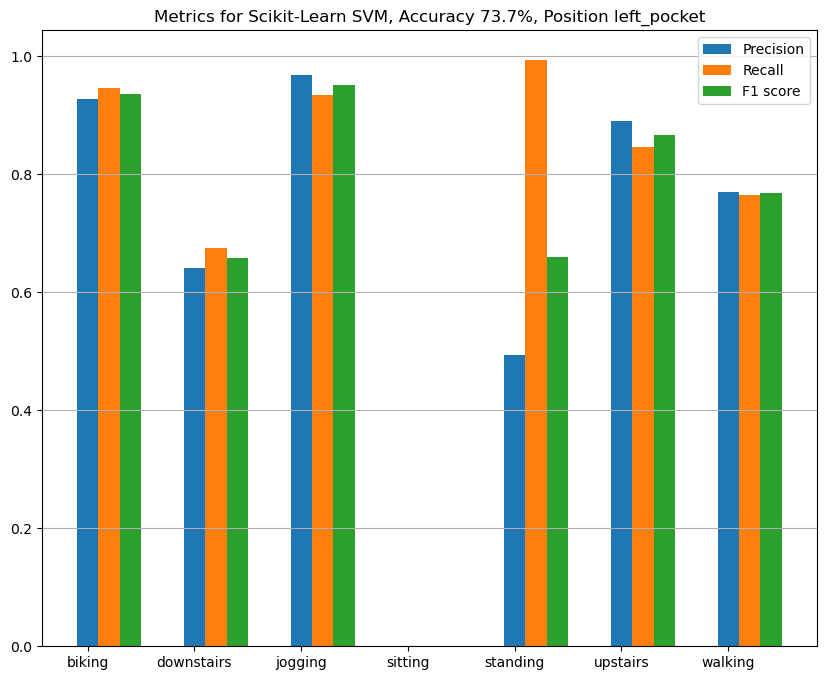

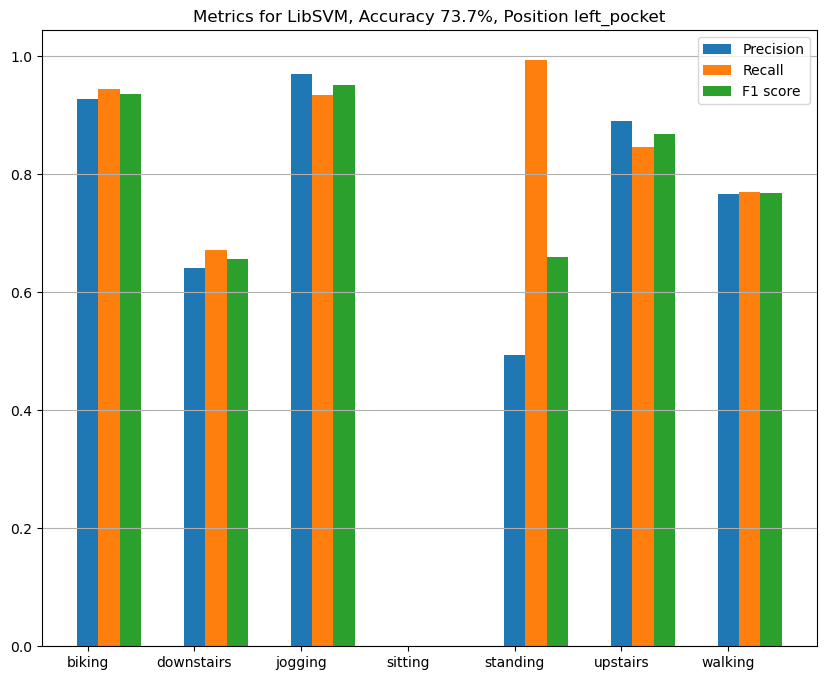

In [28]:
for i, conf_matrix in enumerate([total_confusion_matrix_sklearn_svm, total_confusion_matrix_lib_svm]):
    accuracy, true_positives, false_positives, false_negatives, true_negatives = get_positive_negatives(conf_matrix)
    precisions, recalls, f1_scores = get_metrics(true_positives, false_positives, false_negatives, true_negatives)
    plot_metrics(accuracy, precisions, recalls, f1_scores, classifiers[i], title=f'Metrics for {classifiers[i]}, Accuracy {accuracy*100:.1f}%, Position {position}')
